# 实战 Kaggle 比赛：图像分类 (CIFAR-10)

之前几节中，我们一直在使用深度学习框架的高级API直接获取张量格式的图像数据集。
但是在实践中，图像数据集通常以图像文件的形式出现。
本节将从原始图像文件开始，然后逐步组织、读取并将它们转换为张量格式。

我们在 sec_image_augmentation 中对CIFAR-10数据集做了一个实验。CIFAR-10是计算机视觉领域中的一个重要的数据集。
本节将运用我们在前几节中学到的知识来参加CIFAR-10图像分类问题的Kaggle竞赛，(**比赛的网址是https://www.kaggle.com/c/cifar-10**)。

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from torchvision import models


# from d2l import torch as d2l
import sys
sys.path.append("..") 
import d2lzh_pytorch.torch_package as d2l

P:\python\anaconda3\envs\d2l_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 获取并组织数据集

比赛数据集分为训练集和测试集，其中训练集包含50000张、测试集包含300000张图像。
在测试集中，10000张图像将被用于评估，而剩下的290000张图像将不会被进行评估，包含它们只是为了防止手动标记测试集并提交标记结果。
两个数据集中的图像都是png格式，高度和宽度均为32像素并有三个颜色通道（RGB）。
这些图片共涵盖10个类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车。
 :numref:`fig_kaggle_cifar10`的左上角显示了数据集中飞机、汽车和鸟类的一些图像。

### 下载数据集

登录Kaggle后，我们可以点击 :numref:`fig_kaggle_cifar10`中显示的CIFAR-10图像分类竞赛网页上的“Data”选项卡，然后单击“Download All”按钮下载数据集。
在`../data`中解压下载的文件并在其中解压缩`train.7z`和`test.7z`后，在以下路径中可以找到整个数据集：

* `../data/cifar-10/train/[1-50000].png`
* `../data/cifar-10/test/[1-300000].png`
* `../data/cifar-10/trainLabels.csv`
* `../data/cifar-10/sampleSubmission.csv`

`train`和`test`文件夹分别包含训练和测试图像，`trainLabels.csv`含有训练图像的标签，
`sample_submission.csv`是提交文件的范例。

为了便于入门，[**我们提供包含前1000个训练图像和5个随机测试图像的数据集的小规模样本**]。
要使用Kaggle竞赛的完整数据集，需要将以下`demo`变量设置为`False`。


In [2]:
def loadData():
    # 加载 kaggle_cifar10_tiny.zip 数据集
    d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                    '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
    # 如果使用完整的Kaggle竞赛的数据集，设置demo为False
    demo = True

    if demo:
        data_dir = d2l.download_extract('cifar10_tiny')
    else:
        data_dir = '../data/cifar-10/'
    return data_dir

In [3]:
data_dir = loadData()

download函数将使用 X:\big_ai_files\d2l_data\data 作为缓存地址


In [4]:
data_dir

'X:\\big_ai_files\\d2l_data\\data\\kaggle_cifar10_tiny'

In [4]:
# 自定义数据集地址

# data_dir = r"X:\big_ai_files\d2l_data\data\kaggle_cifar10_tiny.zip"


In [5]:

def read_csv_labels(fname):
    """
    读取fname来给标签字典返回一个文件名
    """
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]

    tokens = [l.rstrip().split(',') for l in lines]
    # print(tokens)
    return dict(((name, label) for name, label in tokens))

In [6]:
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))

print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))
print("# 标签类别: ", set(labels.values()))


for k,v in labels.items():
    print(k, v)
    break

# 训练样本 : 1000
# 类别 : 10
# 标签类别:  {'airplane', 'truck', 'dog', 'horse', 'frog', 'ship', 'bird', 'cat', 'deer', 'automobile'}
1 frog


In [7]:
def copyfile(filename, target_dir):
    """
    将文件复制到目标目录
    """
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)


    
def reorg_train_valid(data_dir, labels, valid_ratio):
    """
    将验证集从原始的训练集中拆分出来
    """
    print("data_dir: ", data_dir)
    
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    
        
    # 文件列表: ['1.png', .... , '999.png', '1000.png']
    train_file_list = os.listdir(os.path.join(data_dir, 'train'))
    # print("train_file_list", train_file_list)
    
    # 遍历 1000次
    for train_file in train_file_list:
        
        # 标签
        label = labels[train_file.split('.')[0]]
        # print("当前图片文件: %s \t label是: %s" % (train_file, label))

        # 全路径 /mnt/325E98425E980131/ai_data/kaggle/kaggle_cifar10_tiny/train/1000.png
        fname = os.path.join(data_dir, 'train', train_file)

        # 目标地址
        target_path_v1 = os.path.join(data_dir, 'train_valid_test', 'train_valid', label)
        copyfile(fname, target_path_v1)

        
        if label not in label_count or label_count[label] < n_valid_per_label:
            
            target_path_v2 = os.path.join(data_dir,
                                         'train_valid_test',
                                         'valid', label)
            
            copyfile(fname, target_path_v2)
            label_count[label] = label_count.get(label, 0) + 1
            
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))

    print('n_valid_per_label: ', n_valid_per_label)  # 8
    return n_valid_per_label


# 重组 测试集
def reorg_test(data_dir):
    """
    在预测期间整理测试集，以方便读取
    """
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test','unknown'))


# 最后，我们使用一个函数来[**调用前面定义的函数**]
# `read_csv_labels`、`reorg_train_valid`  和`reorg_test`。
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

在这里，我们只将样本数据集的批量大小设置为32。
在实际训练和测试中，应该使用Kaggle竞赛的完整数据集，并将`batch_size`设置为更大的整数，例如128。
我们将10％的训练样本作为调整超参数的验证集。

In [8]:
demo = True
batch_size = 32 if demo else 128
valid_ratio = 0.1


# 文件操作, 清洗分类
reorg_cifar10_data(data_dir, valid_ratio)

data_dir:  X:\big_ai_files\d2l_data\data\kaggle_cifar10_tiny
n_valid_per_label:  8


## [**图像增广**]

我们使用图像增广来解决过拟合的问题。例如在训练中，我们可以随机水平翻转图像。
我们还可以对彩色图像的三个RGB通道执行标准化。
下面，我们列出了其中一些可以调整的操作。

In [9]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),

    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),

    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']
]

train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset,
                                batch_size,
                                shuffle=True,
                                drop_last=True
                                )
    for dataset in (train_ds, train_valid_ds)
]

valid_iter = torch.utils.data.DataLoader(valid_ds,
                                         batch_size,
                                         shuffle=False,
                                         drop_last=True
                                         )

test_iter = torch.utils.data.DataLoader(test_ds,
                                        batch_size,
                                        shuffle=False,
                                        drop_last=False)

在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性。


## 读取数据集

接下来，我们[**读取由原始图像组成的数据集**]，每个样本都包括一张图片和一个标签。


在训练期间，我们需要[**指定上面定义的所有图像增广操作**]。
当验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性。
在最终预测之前，我们根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标记的数据。


## 定义[**模型**]

我们定义了Resnet-18模型。

In [10]:
def get_net():
    num_classes = 10
    # net = d2l.resnet18(num_classes, 3)
    # net = models.resnet18(pretrained=True)weight
    net = models.resnet18(weights=True)
    
    print('网络初始化之前: ',net.fc)
    net.fc = nn.Linear(512, num_classes)
    
    print('重新定义网络后', net.fc)
    return net

In [11]:
loss = nn.CrossEntropyLoss(reduction="none")

## 定义[**训练函数**]

我们将根据模型在验证集上的表现来选择模型并调整超参数。
下面我们定义了模型训练函数`train`。


In [12]:
def train(net, 
          train_iter, valid_iter, 
          num_epochs, lr, wd, devices, lr_period, lr_decay):
    
    
    # 方式一
    #trainer = torch.optim.SGD(net.parameters(), 
    #                          lr=lr, 
    #                          momentum=0.9,
    #                          weight_decay=wd
    #                        )
    
    # 方式二, 测试
    output_params = list(map(id, net.fc.parameters()))
    feature_params = filter(lambda p: id(p) not in output_params, net.parameters())
    trainer = torch.optim.SGD([{'params': feature_params},
                               {'params': net.fc.parameters(), 'lr': lr * 10}],
                              lr=lr, weight_decay=0.001)
    
    
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    
    if valid_iter is not None:
        legend.append('valid acc')
        
    animator = d2l.Animator(xlabel='epoch', 
                            xlim=[1, num_epochs],
                            legend=legend
                           )
    
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        
        for i, (features, labels) in enumerate(train_iter):
            
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
                
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
            pass
        
        scheduler.step()
        
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
        
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## [**训练和验证模型**]

现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。
例如，我们可以增加周期的数量。当`lr_period`和`lr_decay`分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9。
为便于演示，我们在这里只训练20个周期。

In [13]:
devices = d2l.try_all_gpus()

num_epochs = 20
lr = 2e-4
wd = 5e-4

lr_period = 4
lr_decay = 0.9


net = get_net()

P:\python\anaconda3\envs\d2l_pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\t14_mylady/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 33.1MB/s]

网络初始化之前:  Linear(in_features=512, out_features=1000, bias=True)
重新定义网络后 Linear(in_features=512, out_features=10, bias=True)


In [ ]:
# net.state_dict()

train loss 0.288, train acc 0.913, valid acc 0.547
1673.1 examples/sec on [device(type='cuda', index=0)]


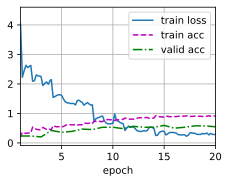

In [14]:

# 训练
train(net, 
      train_iter, valid_iter, 
      num_epochs, 
      lr,
      wd, 
      devices, 
      lr_period,
      lr_decay
     )

In [ ]:
# net.state_dict()

模型保存

In [15]:
# 模型保存
PATH = 'kaggle_cifar10_tiny_save.pt'


# torch.save(net, PATH)  # 保存整个模型

# torch.save(net.state_dict(), PATH)  # 保存模型参数
torch.save(net, PATH)   # 全保存

## 在 Kaggle 上[**对测试集进行分类并提交结果**]

在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。


In [ ]:
# 训练
train(net, train_valid_iter, None, 
      num_epochs, 
      lr, 
      wd, 
      devices, 
      lr_period, 
      lr_decay
     )

模型加载

In [16]:
# net = torch.load(PATH)

net_models = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)# .eval()
# net = nn.DataParallel(net, device_ids=devices).to(devices[0])
net_models.fc = nn.Linear(512, 10)
# net_models.load_state_dict(torch.load(PATH))

net_models = torch.load(PATH)  # 读取

# 转到GPU上
net_models = net_models.to(devices[0])

print("加载保存的模型...")

加载保存的模型...


In [99]:
# net_models.state_dict()

In [18]:
# net , preds = get_net(), []
# net = get_net()
preds = []


for X, _ in test_iter:
    X = X.to(devices[0])
    y_hat = net_models(X)
    
    # print("预测y_hat; ", y_hat)
    res = y_hat.argmax(dim=1).type(torch.int32).cpu().numpy()
    
    print("res: ", res)
    
    preds.extend(res)
    pass


#  1              2           3       4       5
# {'airplane', 'automobile', 'bird',  'cat',  'deer', 
# 'dog',       'frog',       'horse', 'ship', 'truck'}
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))  # 


# 打印标签  
for i in range(10):
    print('%s 标签是: %s' %(i, train_valid_ds.classes[i]))
    pass


res:  [8 6 0 6 5]
0 标签是: airplane
1 标签是: automobile
2 标签是: bird
3 标签是: cat
4 标签是: deer
5 标签是: dog
6 标签是: frog
7 标签是: horse
8 标签是: ship
9 标签是: truck


In [ ]:

# df 未定义
print(df)
df = pd.DataFrame({
    'id': sorted_ids, 
    'label': preds
})


df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('kaggle_cifar10_tiny_submission.csv', index=False)

向Kaggle提交结果的方法与`sec_kaggle_house`中的方法类似，上面的代码将生成一个
`submission.csv`文件，其格式符合Kaggle竞赛的要求。

## 小结

* 将包含原始图像文件的数据集组织为所需格式后，我们可以读取它们。


## 练习

1. 在这场Kaggle竞赛中使用完整的CIFAR-10数据集。将超参数设为`batch_size = 128`，`num_epochs = 100`，`lr = 0.1`，`lr_period = 50`，`lr_decay = 0.1`。看看在这场比赛中能达到什么准确度和排名。能进一步改进吗？
1. 不使用图像增广时，能获得怎样的准确度？